In [1]:
from rdkit import Chem
import numpy as np
from collections import defaultdict
import sys
import pickle
import os
sys.path.append('../')
sys.path.append('../data_processing/')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from tqdm import tqdm
import py3Dmol

In [2]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from script_utils import load_qm9_data

In [4]:
generated_path = '../lightning_logs/vp_bridge_2024-05-13_00_09_54.680600/vp'

In [5]:
mols = []

for file in tqdm(os.listdir(generated_path)):
    m = Chem.MolFromMolFile(os.path.join(generated_path, file))
    mols.append(m)

  0%|                                                                                                                                                                    | 0/7169 [00:00<?, ?it/s][15:04:54] atom 23 has specified valence (1) smaller than the drawn valence 2.
[15:04:54] atom 17 has specified valence (2) smaller than the drawn valence 3.
[15:04:54] atom 18 has specified valence (3) smaller than the drawn valence 4.
[15:04:54] atom 32 has specified valence (1) smaller than the drawn valence 2.
[15:04:54] atom 24 has specified valence (3) smaller than the drawn valence 4.
[15:04:54] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:04:54] atom 14 has specified valence (4) smaller than the drawn valence 5.
[15:04:54] atom 13 has specified valence (3) smaller than the drawn valence 4.
[15:04:54] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:04:54] atom 0 has specified valence (1) smaller than the drawn valence 2.
  0%|▍           

[15:04:54] atom 8 has specified valence (1) smaller than the drawn valence 2.
  2%|███▌                                                                                                                                                     | 167/7169 [00:00<00:37, 186.78it/s][15:04:54] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:04:54] atom 11 has specified valence (3) smaller than the drawn valence 4.
[15:04:54] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:04:54] atom 8 has specified valence (4) smaller than the drawn valence 5.
[15:04:54] atom 22 has specified valence (1) smaller than the drawn valence 2.
[15:04:55] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:04:55] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:04:55] atom 19 has specified valence (1) smaller than the drawn valence 2.
[15:04:55] atom 20 has specified valence (4) smaller than the drawn valence 5.
[15:04:55] atom 4 has 

  4%|██████▊                                                                                                                                                  | 319/7169 [00:01<00:29, 232.74it/s][15:04:55] atom 11 has specified valence (3) smaller than the drawn valence 4.
[15:04:55] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 2 has specified valence (2) smaller than the drawn valence 3.
[15:04:56] atom 12 has specified valence (4) smaller than the drawn valence 5.
[15:04:56] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 17 has specified valence (4) smaller than the drawn valence 5.
[15:04:56] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 3 has

[15:04:56] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 20 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 23 has specified valence (3) smaller than the drawn valence 4.
[15:04:56] atom 31 has specified valence (3) smaller than the drawn valence 4.
[15:04:56] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 16 has specified valence (3) smaller than the drawn valence 4.
  7%|██████████▎                                                                                                                                              | 482/7169 [00:02<00:37, 176.52it/s][15:04:56] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 11 has specified valence (4) smaller than the drawn valence 5.
[15:04:56] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:04:56] atom 15 

[15:04:57] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 19 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 10 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 24 has specified valence (4) smaller than the drawn valence 5.
[15:04:57] atom 13 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 28 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:04:57] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 8 has specified valence (1) smaller than the 

[15:04:57] atom 11 has specified valence (1) smaller than the drawn valence 2.
 10%|███████████████▋                                                                                                                                         | 733/7169 [00:03<00:20, 310.74it/s][15:04:57] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 5 has specified valence (4) smaller than the drawn valence 5.
[15:04:57] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 20 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 6 has specified valence (4) smaller than the drawn valence 5.
[15:04:57] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 13 h

 12%|██████████████████▎                                                                                                                                      | 857/7169 [00:03<00:17, 370.63it/s][15:04:57] atom 8 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 5 has specified valence (2) smaller than the drawn valence 3.
[15:04:57] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:04:57] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 30 has specified valence (4) smaller than the drawn valence 5.
[15:04:57] atom 22 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:04:57] atom 20 has specified valence (3) smaller than the drawn valence 4.
[15:04:57] atom 35 has specified valence (2) smaller than the drawn valence 3.
[15:04:57] atom 1 has 

 14%|████████████████████▉                                                                                                                                    | 983/7169 [00:04<00:15, 399.79it/s][15:04:58] atom 12 has specified valence (4) smaller than the drawn valence 5.
[15:04:58] atom 12 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 13 has specified valence (3) smaller than the drawn valence 4.
[15:04:58] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 7 has specified valence (3) smaller than the drawn valence 4.
[15:04:58] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:04:58] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 16 has

 15%|███████████████████████▍                                                                                                                                | 1104/7169 [00:04<00:15, 392.54it/s][15:04:58] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 7 has specified valence (4) smaller than the drawn valence 5.
[15:04:58] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 19 has specified valence (2) smaller than the drawn valence 3.
[15:04:58] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:04:58] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 23 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 15 has specified valence (4) smaller than the drawn valence 5.
[15:04:58] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 14 h

[15:04:58] atom 22 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 23 has specified valence (4) smaller than the drawn valence 5.
[15:04:58] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:04:58] atom 7 has specified valence (2) smaller than the drawn valence 3.
[15:04:58] atom 8 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 22 has specified valence (3) smaller than the drawn valence 4.
[15:04:58] atom 27 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 1 has specified valence (4) smaller than the drawn valence 5.
 18%|██████████████████████████▉                                                                                                                             | 1273/7169 [00:04<00:14, 411.43it/s][15:04:58] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:04:58] atom 5 has specified valence (3) smaller than the drawn valence 4.
[15:04:58] atom 19 has

[15:04:59] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] atom 10 has specified valence (1) smaller than the drawn valence 2.
 20%|██████████████████████████████▋                                                                                                                         | 1446/7169 [00:05<00:14, 404.07it/s][15:04:59] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:04:59] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] Explicit valence for atom # 8 N, 4, is greater than permitted
[15:04:59] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:04:59] atom 14 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:04:59] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:04:59] atom 5 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] Explicit valence for 

 22%|█████████████████████████████████▍                                                                                                                      | 1575/7169 [00:05<00:13, 414.45it/s][15:04:59] atom 14 has specified valence (2) smaller than the drawn valence 3.
[15:04:59] atom 21 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:04:59] atom 19 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:04:59] atom 11 has specified valence (5) smaller than the drawn valence 6.
[15:04:59] atom 20 has specified valence (3) smaller than the drawn valence 4.
[15:04:59] atom 23 has specified valence (1) smaller than the drawn valence 2.
[15:04:59] atom 16 has specified valence (4) smaller than the drawn valence 5.
[15:04:59] atom 26 has specified valence (1) smaller than the drawn valence 2.
[15:04:59] atom 9 has s

[15:05:00] atom 27 has specified valence (5) smaller than the drawn valence 6.
[15:05:00] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 9 has specified valence (1) smaller than the drawn valence 2.
 24%|█████████████████████████████████████                                                                                                                   | 1747/7169 [00:06<00:13, 387.64it/s][15:05:00] atom 1 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 8 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 29 ha

[15:05:00] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 15 has specified valence (4) smaller than the drawn valence 5.
[15:05:00] atom 14 has specified valence (3) smaller than the drawn valence 4.
 26%|███████████████████████████████████████▋                                                                                                                | 1872/7169 [00:06<00:13, 383.00it/s][15:05:00] atom 21 has specified valence (4) smaller than the drawn valence 5.
[15:05:00] atom 0 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 8 ha

 28%|██████████████████████████████████████████▌                                                                                                             | 2008/7169 [00:06<00:12, 409.84it/s][15:05:00] atom 22 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 13 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 20 has specified valence (4) smaller than the drawn valence 5.
[15:05:00] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 8 has specified valence (1) smaller than the drawn valence 2.
[15:05:00] atom 15 has specified valence (2) smaller than the drawn valence 3.
[15:05:00] atom 0 has specified valence (3) smaller than the drawn valence 4.
[15:05:00] atom 21 

 30%|██████████████████████████████████████████████▏                                                                                                         | 2181/7169 [00:07<00:14, 349.41it/s][15:05:01] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:05:01] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:05:01] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 21 has specified valence (4) smaller than the drawn valence 5.
[15:05:01] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:05:01] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:05:01] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 15 has 

[15:05:01] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:01] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:01] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:05:01] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 8 has specified valence (4) smaller than the drawn valence 5.
[15:05:01] atom 25 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 9 has specified valence (4) smaller than the drawn valence 5.
[15:05:01] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:01] atom 10 has specified valence (3) smaller than the

[15:05:02] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:02] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 6 has specified valence (4) smaller than the drawn valence 5.
[15:05:02] atom 22 has specified valence (4) smaller than the drawn valence 5.
[15:05:02] atom 28 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:05:02] atom 5 has specified valence (2) smaller than the drawn valence 3.
 34%|████████████████████████████████████████████████████▎                                                                                                   | 2468/7169 [00:08<00:12, 362.73it/s][15:05:02] atom 2 has s

[15:05:02] atom 1 has specified valence (3) smaller than the drawn valence 4.
[15:05:02] atom 3 has specified valence (5) smaller than the drawn valence 6.
[15:05:02] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 10 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 20 has specified valence (3) smaller than the drawn valence 4.
[15:05:02] atom 12 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 16 has specified valence (3) smaller than the drawn valence 4.
[15:05:02] atom 7 has specified valence (4) smaller than the drawn valence 5.
[15:05:02] atom 10 has specified valence (1) smaller than the drawn valence 2.
 37%|███████████████████████████████████████████████████████▉                                                                           

 39%|██████████████████████████████████████████████████████████▌                                                                                             | 2765/7169 [00:08<00:11, 392.71it/s][15:05:02] atom 25 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 2 has specified valence (4) smaller than the drawn valence 5.
[15:05:02] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 7 has specified valence (2) smaller than the drawn valence 3.
[15:05:02] atom 29 has specified valence (3) smaller than the drawn valence 4.
[15:05:02] atom 5 has specified valence (3) smaller than the drawn valence 4.
[15:05:02] atom 0 has specified valence (2) smaller than the drawn valence 3.
[15:05:02] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] atom 7 has specified valence (4) smaller than the drawn valence 5.
[15:05:02] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:02] Explicit val

 41%|██████████████████████████████████████████████████████████████▏                                                                                         | 2934/7169 [00:09<00:10, 398.97it/s][15:05:03] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 6 has specified valence (4) smaller than the drawn valence 5.
[15:05:03] atom 9 has specified valence (4) smaller than the drawn valence 5.
[15:05:03] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:03] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 13 has specified valence (3) smaller than the drawn valence 4.
[15:05:03] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 14 has s

 43%|█████████████████████████████████████████████████████████████████▉                                                                                      | 3109/7169 [00:09<00:09, 409.47it/s][15:05:03] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 1 has specified valence (4) smaller than the drawn valence 5.
[15:05:03] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:03] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:05:03] atom 14 has specified valence (2) smaller than the drawn valence 3.
[15:05:03] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 10 has s

[15:05:03] Explicit valence for atom # 3 N, 4, is greater than permitted
[15:05:03] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:03] atom 17 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 5 has specified valence (4) smaller than the drawn valence 5.
[15:05:03] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:03] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 6 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 26 has specified valence (5) smaller than the drawn valence 6.
[15:05:04] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 22 has specified valence (4) smaller than the drawn valence 5.
[15:05:04] atom 3 has specified valence (1) smaller than the dr

[15:05:04] atom 9 has specified valence (4) smaller than the drawn valence 5.
[15:05:04] atom 9 has specified valence (1) smaller than the drawn valence 2.
 48%|█████████████████████████████████████████████████████████████████████████▍                                                                              | 3464/7169 [00:10<00:08, 445.92it/s][15:05:04] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 18 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 10 has specified valence (5) smaller than the drawn valence 6.
[15:05:04] atom 4 has specified valence (2) smaller than the drawn valence 3.
[15:05:04] atom 8 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 10 has s

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                          | 3642/7169 [00:10<00:08, 414.73it/s][15:05:04] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 11 has specified valence (4) smaller than the drawn valence 5.
[15:05:04] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 10 has specified valence (1) smaller than the drawn valence 2.
[15:05:04] atom 13 has specified valence (4) smaller than the drawn valence 5.
[15:05:04] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:04] atom 27 ha

 53%|████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3814/7169 [00:11<00:08, 405.77it/s][15:05:05] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 11 has specified valence (3) smaller than the drawn valence 4.
[15:05:05] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:05] atom 2 has specified valence (4) smaller than the drawn valence 5.
[15:05:05] atom 5 has specified valence (2) smaller than the drawn valence 3.
[15:05:05] atom 12 has specified valence (2) smaller than the drawn valence 3.
[15:05:05] atom 0 has specified valence (2) smaller than the drawn valence 3.
[15:05:05] atom 8 has specified valence (3) smaller than the drawn valence 4.
[15:05:05] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 14 ha

 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3935/7169 [00:11<00:11, 293.40it/s][15:05:05] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 8 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:05] atom 20 has specified valence (4) smaller than the drawn valence 5.
[15:05:05] atom 28 has specified valence (2) smaller than the drawn valence 3.
[15:05:05] atom 2 has specified valence (4) smaller than the drawn valence 5.
[15:05:05] atom 2 has specified valence (4) smaller than the drawn valence 5.
[15:05:05] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:05] atom 19 has 

[15:05:06] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 0 has specified valence (4) smaller than the drawn valence 5.
[15:05:06] atom 17 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 19 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:06] atom 22 has specified valence (1) smaller than the drawn valence 2.
 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 4095/7169 [00:12<00:10, 303.36it/s][15:05:06] atom 5 has specified valence (2) smaller than the drawn valence 3.
[15:05:06] atom 22 has specified valence (3) smaller than the drawn valence 4.
[15:05:06] atom 8 has 

[15:05:06] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 13 has specified valence (4) smaller than the drawn valence 5.
[15:05:06] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 19 has specified valence (4) smaller than the drawn valence 5.
[15:05:06] atom 20 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 5 has specified valence (3) smaller than the drawn valence 4.
[15:05:06] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] atom 10 has specified valence (2) smaller than the drawn valence 3.
[15:05:06] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:06] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:05:06] atom 1 has specified valence (4) smaller than the drawn valence 5.
[15:05:06] atom 9 has specified valence (1) smaller than the dr

 61%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 4383/7169 [00:13<00:07, 391.73it/s][15:05:07] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 16 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 17 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 23 has specified valence (4) smaller than the drawn valence 5.
[15:05:07] atom 10 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 16 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 12 has specified valence (4) smaller than the drawn valence 5.
[15:05:07] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 9 h

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4558/7169 [00:13<00:06, 416.76it/s][15:05:07] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 12 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 0 has specified valence (4) smaller than the drawn valence 5.
[15:05:07] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 13 has 

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4723/7169 [00:13<00:06, 386.72it/s][15:05:07] atom 6 has specified valence (4) smaller than the drawn valence 5.
[15:05:07] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 19 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 2 has specified valence (2) smaller than the drawn valence 3.
[15:05:07] atom 19 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:07] atom 1 has specified valence (2) smaller than the drawn valence 3.
[15:05:07] atom 4 has specified valence (5) smaller than the drawn valence 6.
[15:05:07] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:07] atom 10 has 

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 4887/7169 [00:14<00:05, 393.40it/s][15:05:08] atom 8 has specified valence (2) smaller than the drawn valence 3.
[15:05:08] atom 16 has specified valence (3) smaller than the drawn valence 4.
[15:05:08] atom 19 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 5 has specified valence (4) smaller than the drawn valence 5.
[15:05:08] atom 25 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 0 has specified valence (3) smaller than the drawn valence 4.
[15:05:08] atom 1 has specified valence (4) smaller than the drawn valence 5.
[15:05:08] atom 8 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 26 has

[15:05:08] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:08] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 22 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 9 has specified valence (4) smaller than the drawn valence 5.
[15:05:08] atom 10 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 0 has specified valence (2) smaller than the drawn valence 3.
[15:05:08] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 8 has specified valence (4) smaller than the drawn valence 5.
[15:05:08] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:08] atom 15 has specified valence (3) smaller than the drawn valence 4.
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                          

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5210/7169 [00:15<00:05, 368.11it/s][15:05:09] atom 17 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 19 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 2 has specified valence (5) smaller than the drawn valence 6.
[15:05:09] atom 10 has specified valence (4) smaller than the drawn valence 5.
[15:05:09] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 18 has specified valence (4) smaller than the drawn valence 5.
[15:05:09] atom 20 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] Explicit valence for atom # 5 N, 4, is greater than permitted
[15:05:09] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 23 has s

[15:05:09] atom 4 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 12 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 12 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 3 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 6 has specified valence (2) smaller than the drawn valence 3.
[15:05:09] atom 16 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 12 has specified valence (1) smaller than t

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5507/7169 [00:15<00:03, 420.65it/s][15:05:09] atom 12 has specified valence (4) smaller than the drawn valence 5.
[15:05:09] atom 20 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 12 has specified valence (4) smaller than the drawn valence 5.
[15:05:09] atom 0 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 5 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 24 has specified valence (1) smaller than the drawn valence 2.
[15:05:09] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:05:09] atom 19 has specified valence (4) smaller than the drawn valence 5.
[15:05:09] atom 16 has specified valence (2) smaller than the drawn valence 3.
[15:05:09] atom 0 h

[15:05:10] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:05:10] atom 12 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:05:10] atom 18 has specified valence (3) smaller than the drawn valence 4.
[15:05:10] atom 28 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 4 has specified valence (5) smaller than the drawn valence 6.
[15:05:10] atom 17 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 23 has specified valence (4) smaller than the drawn valence 5.
[15:05:10] atom 10 has specified valence (4) smaller than the drawn valence 5.
[15:05:10] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 8 has specified valence (3) smaller than

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 5764/7169 [00:16<00:05, 275.10it/s][15:05:10] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 19 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 20 has specified valence (4) smaller than the drawn valence 5.
[15:05:10] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 8 has specified valence (4) smaller than the drawn valence 5.
[15:05:10] atom 13 has specified valence (4) smaller than the drawn valence 5.
[15:05:10] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:10] atom 20 has specified valence (3) smaller than the drawn valence 4.
[15:05:10] atom 30 has specified valence (2) smaller than the drawn valence 3.
[15:05:10] atom 14 has specified valence (4) smaller than the drawn valence 5.
[15:05:10] atom 18 

[15:05:11] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:11] atom 9 has specified valence (4) smaller than the drawn valence 5.
[15:05:11] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 2 has specified valence (4) smaller than the drawn valence 5.
[15:05:11] atom 20 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] Explicit valence for atom # 6 N, 4, is greater than permitted
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 5906/7169 [00:17<00:04, 292.54it/s][15:05:11] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 16 has specified valence (4) smaller than the drawn valence 5.
[15:05:11] atom 5 has specified valence (5) smaller than the drawn valence 6.
[15:05:11] atom 15 has spe

[15:05:11] atom 15 has specified valence (2) smaller than the drawn valence 3.
[15:05:11] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:11] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:05:11] atom 10 has specified valence (4) smaller than the drawn valence 5.
[15:05:11] atom 22 has specified valence (2) smaller than the drawn valence 3.
[15:05:11] atom 23 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 12 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 9 has specified valence (4) smaller than the drawn valence 5.
[15:05:11] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 2 has specified valence (3) smaller than the drawn valence 4.
[15:05:11] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:11] atom 14 has specified valence (4) smaller than the d

[15:05:12] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 12 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 15 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 9 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 11 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 6 has specified valence (1) smaller than the drawn valence 2.
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6174/7169 [00:18<00:03, 301.18it/s][15:05:12] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 19 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 7 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 30 ha

[15:05:12] atom 15 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 22 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 29 has specified valence (4) smaller than the drawn valence 5.
[15:05:12] atom 3 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 17 has specified valence (3) smaller than the drawn valence 4.
[15:05:12] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:12] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:05:12] atom 13 has specified valence (3) smaller th

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 6518/7169 [00:19<00:01, 460.01it/s][15:05:13] atom 1 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 9 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 25 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 21 has specified valence (2) smaller than the drawn valence 3.
[15:05:13] atom 17 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 15 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 0 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 1 ha

[15:05:13] atom 10 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 28 has specified valence (2) smaller than the drawn valence 3.
[15:05:13] atom 0 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 6 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 11 has specified valence (4) smaller than the drawn valence 5.
[15:05:13] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 22 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 10 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 12 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 4 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 8 has specified valence (4) smaller than

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 6824/7169 [00:19<00:00, 398.58it/s][15:05:13] atom 18 has specified valence (3) smaller than the drawn valence 4.
[15:05:13] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 22 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 5 has specified valence (4) smaller than the drawn valence 5.
[15:05:13] atom 6 has specified valence (2) smaller than the drawn valence 3.
[15:05:13] atom 1 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 6 has specified valence (4) smaller than the drawn valence 5.
[15:05:13] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 19 has specified valence (4) smaller than the drawn valence 5.
[15:05:13] atom 18 has specified valence (1) smaller than the drawn valence 2.
[15:05:13] atom 21 h

[15:05:14] atom 8 has specified valence (2) smaller than the drawn valence 3.
[15:05:14] atom 16 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 21 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 24 has specified valence (3) smaller than the drawn valence 4.
[15:05:14] atom 21 has specified valence (3) smaller than the drawn valence 4.
[15:05:14] atom 34 has specified valence (4) smaller than the drawn valence 5.
[15:05:14] atom 35 has specified valence (4) smaller than the drawn valence 5.
[15:05:14] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 4 has specified valence (4) smaller than the drawn valence 5.
[15:05:14] atom 5 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 7 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 13 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 17 has specified valence (4) smaller than

[15:05:14] atom 14 has specified valence (1) smaller than the drawn valence 2.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7142/7169 [00:20<00:00, 764.48it/s][15:05:14] atom 27 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 5 has specified valence (2) smaller than the drawn valence 3.
[15:05:14] atom 11 has specified valence (3) smaller than the drawn valence 4.
[15:05:14] atom 13 has specified valence (3) smaller than the drawn valence 4.
[15:05:14] atom 14 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 20 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 2 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] atom 26 has specified valence (1) smaller than the drawn valence 2.
[15:05:14] Explicit valence for atom # 5 N, 4, is greater than permitted
[15:05:14] atom 15 has s

In [6]:
len(os.listdir(generated_path)), len(mols)

(7169, 7169)

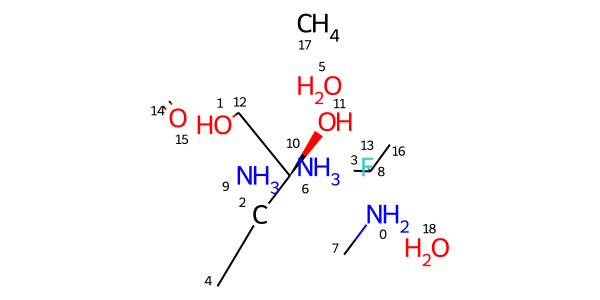

In [17]:
# m = mols[12]
example = '/data/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/vp_bridge_2024-05-13_00_09_54.680600/vp/1azm_A_rec_4wr7_3tv_lig_tt_min_0.sdf'
m = Chem.MolFromMolFile(example)
m

In [18]:
v = py3Dmol.view()
v.addModel(open(example).read())
v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.